<a id='Cost Efficiency Clustering'></a>

## <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">  Clustering U.S. Home Health Agencies by Cost and Quality (2025)
    
<font color=darkblue>This notebook uses unsupervised learning to identify efficiency-based clusters of home health agencies. The goal is to support value-based care optimization by analyzing medicare cost, episode volume, and quality metrics.
 </font> 

<span style="font-family: Arial; font-weight:bold;font-size:1.7em;color:#00b3e5;">Key Features Kept for Modeling
### Use a subset of the dataset representing cost, quality, and care outcomes:

| Column                | Description                                    |
| --------------------- | ---------------------------------------------- |
| `Provider`            | Name of the home health agency                 |
| `State`               | Location (can be used for geo-segmentation)    |
| `Ownership`           | Type (e.g., Non-Profit, Proprietary)           |
| `Medicare_Cost_Ratio` | Cost ratio vs national average                 |
| `Episode_Count`       | Volume of Medicare-covered episodes            |
| `Quality_Star`        | CMS quality star rating (1–5 scale)            |
| `PPH_Rate`            | Preventable hospitalization risk-adjusted rate |
| `DTC_Rate`            | Discharge to community rate                    |
| `PPR_Rate`            | Preventable readmission risk-adjusted rate     |


<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1.1 Load the libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1.2. Import the dataset (HH_Provider_Apr2025.csv)

In [2]:
# Load dataset
data = pd.read_csv('../data/HH_Provider_Apr2025.csv')

<span style="font-family: Arial; font-weight:bold;font-size:1.7em;color:#00b3e5;">1.3. Feature Selection and Data Cleaning

In [3]:
# ---- Step 1: Initial Cleanup ----
# Remove footnote columns, raw numerators/denominators, addresses, and contact details
columns_to_drop = [col for col in data.columns if any(keyword in col for keyword in [
    'Footnote', 'Numerator', 'Denominator', 'Address', 'Telephone', 'ZIP', 'City/Town',
    'Transfer of Health Information', 'Certification Date', 'Offers', 'CMS Certification'
])]

data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# ---- Step 2: Rename columns for clarity ----
data.rename(columns={
    'Provider Name': 'Provider',
    'Type of Ownership': 'Ownership',
    'Quality of patient care star rating': 'Quality_Star',
    'DTC Risk-Standardized Rate': 'DTC_Rate',
    'PPR Risk-Standardized Rate': 'PPR_Rate',
    'PPH Risk-Standardized Rate': 'PPH_Rate',
    'How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally': 'Medicare_Cost_Ratio',
    'No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)': 'Episode_Count'
}, inplace=True)

# ---- Step 3: Clean numeric columns ----
numeric_cols = ['Quality_Star', 'DTC_Rate', 'PPR_Rate', 'PPH_Rate', 'Medicare_Cost_Ratio', 'Episode_Count']
for col in numeric_cols:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False).replace('-', pd.NA)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# ---- Step 4: Drop rows with critical missing values ----
data.dropna(subset=numeric_cols, inplace=True)

# ---- Step 5: Summary of cleaned dataset ----
print("Cleaned DataFrame Shape:", data.shape)
print("Remaining Columns:", data.columns.tolist())
print("\nMissing Values Summary:\n", data.isnull().sum())
data.head()

Cleaned DataFrame Shape: (5797, 32)
Remaining Columns: ['State', 'Provider', 'Ownership', 'Quality_Star', "How often the home health team began their patients' care in a timely manner", 'How often the home health team determined whether patients received a flu shot for the current flu season', 'How often patients got better at walking or moving around', 'How often patients got better at getting in and out of bed', 'How often patients got better at bathing', "How often patients' breathing improved", 'How often patients got better at taking their drugs correctly by mouth', 'Changes in skin integrity post-acute care: pressure ulcer/injury', 'How often physician-recommended actions to address medication issues were completely timely', 'Percent of Residents Experiencing One or More Falls with Major Injury', 'Discharge Function Score', 'DTC Observed Rate', 'DTC_Rate', 'DTC Risk-Standardized Rate (Lower Limit)', 'DTC Risk-Standardized Rate (Upper Limit)', 'DTC Performance Categorization', 'PP

,State,Provider,Ownership,Quality_Star,How often the home health team began their patients' care in a timely manner,How often the home health team determined whether patients received a flu shot for the current flu season,How often patients got better at walking or moving around,How often patients got better at getting in and out of bed,How often patients got better at bathing,How often patients' breathing improved,...,PPR Risk-Standardized Rate (Lower Limit),PPR Risk-Standardized Rate (Upper Limit),PPR Performance Categorization,PPH Observed Rate,PPH_Rate,PPH Risk-Standardized Rate (Lower Limit),PPH Risk-Standardized Rate (Upper Limit),PPH Performance Categorization,Medicare_Cost_Ratio,Episode_Count
0,AK,PROVIDENCE HOME HEALTH ALASKA,NON-PROFIT,4.5,91.3,42.3,91.7,94.5,96.2,100.0,...,3.11,5.09,Same As National Rate,10.11,8.37,6.56,10.49,Same As National Rate,0.96,1345.0
2,AK,FAIRBANKS MEMORIAL HOSPITAL HHA,NON-PROFIT,2.5,84.9,53.9,74.4,84.7,82.6,89.5,...,2.61,5.05,Same As National Rate,5.97,7.43,4.41,11.42,Same As National Rate,0.77,439.0
3,AK,ANCORA HOME HEALTH & HOSPICE,PROPRIETARY,4.0,69.7,48.1,87.0,92.7,93.2,93.4,...,3.56,5.25,Same As National Rate,6.32,6.85,5.42,8.59,Better Than National Rate,0.85,2406.0
4,AK,PETERSBURG MEDICAL CENTER HOME,GOVERNMENT OPERATED,1.5,84.7,76.9,70.1,75.2,64.7,72.8,...,2.62,5.86,Same As National Rate,8.06,11.06,6.71,18.52,Same As National Rate,1.09,232.0
5,AK,SOUTH PENINSULA HOSPITAL HHA,GOVERNMENT OPERATED,2.5,97.8,45.7,72.4,84.9,78.8,72.5,...,2.50,5.31,Same As National Rate,7.20,8.82,5.71,13.64,Same As National Rate,1.23,335.0


**There are now 5797 Observations / Rows and 32 Attributes / Columns and there are no missing values.**

**Note** All rows with missing values were deleted.
The columns we’re using for modeling (e.g., Quality_Star, PPH_Rate, DTC_Rate, PPR_Rate, Medicare_Cost_Ratio, Episode_Count) are core numerical features.
Missing values in these columns means that either the agency didn’t report a key metric or CMS didn’t have enough data to calculate it.
Including incomplete rows in unsupervised models like KMeans can distort results because clustering requires distance calculations (e.g., Euclidean), which can’t be computed if values are missing. Imputing the missing values incorrectly may introduce bias or false similarity.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1.4. Scale data and begin modelling

In [4]:
# Define explicitly which columns to include for clustering (only numeric)
numeric_cols = [
    'Quality_Star', 
    'DTC_Rate', 
    'PPR_Rate', 
    'PPH_Rate', 
    'Medicare_Cost_Ratio', 
    'Episode_Count'
]

# Use only these for scaling and clustering
features = data[numeric_cols]

# Now scale and cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Proceed with KMeans
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1.5. Visualize

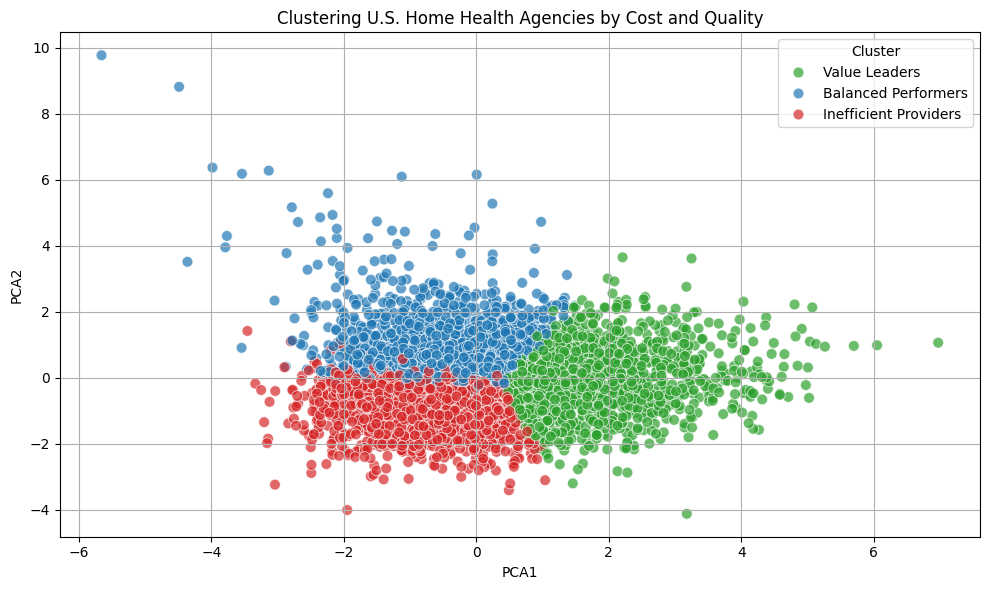

In [5]:
# PCA Transformation
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
data['PCA1'] = components[:, 0]
data['PCA2'] = components[:, 1]

# Map numeric cluster to human-readable labels
label_map = {
    0: "Value Leaders",
    1: "Balanced Performers",
    2: "Inefficient Providers"
}
data['Cluster_Label'] = data['Cluster'].map(label_map)

# Define label order and custom colors
label_order = ["Value Leaders", "Balanced Performers", "Inefficient Providers"]
palette = {
    "Value Leaders": "#2ca02c",         # green
    "Balanced Performers": "#1f77b4",   # blue
    "Inefficient Providers": "#d62728"  # red
}

# Plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster_Label', palette=palette, alpha=0.7, s=60)

# Sort legend manually
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: label_order.index(x[0]))
sorted_labels, sorted_handles = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels, title='Cluster')

plt.title('Clustering U.S. Home Health Agencies by Cost and Quality')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.grid(True)
plt.show()

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1.6. Display Summary

In [6]:
# Assign human-readable labels based on sorted cluster means
cluster_means = data.groupby('Cluster')[numeric_cols].mean().round(2)
cluster_means_sorted = cluster_means.sort_values(by='Medicare_Cost_Ratio')

cluster_labels = {
    cluster_means_sorted.index[0]: "Value Leaders",
    cluster_means_sorted.index[1]: "Balanced Performers",
    cluster_means_sorted.index[2]: "Inefficient Providers"
}

data['Cluster_Label'] = data['Cluster'].map(cluster_labels)

# Create visualizations
sns.set(style="whitegrid")


# Boxplot: Medicare Cost Ratio by Cluster Label

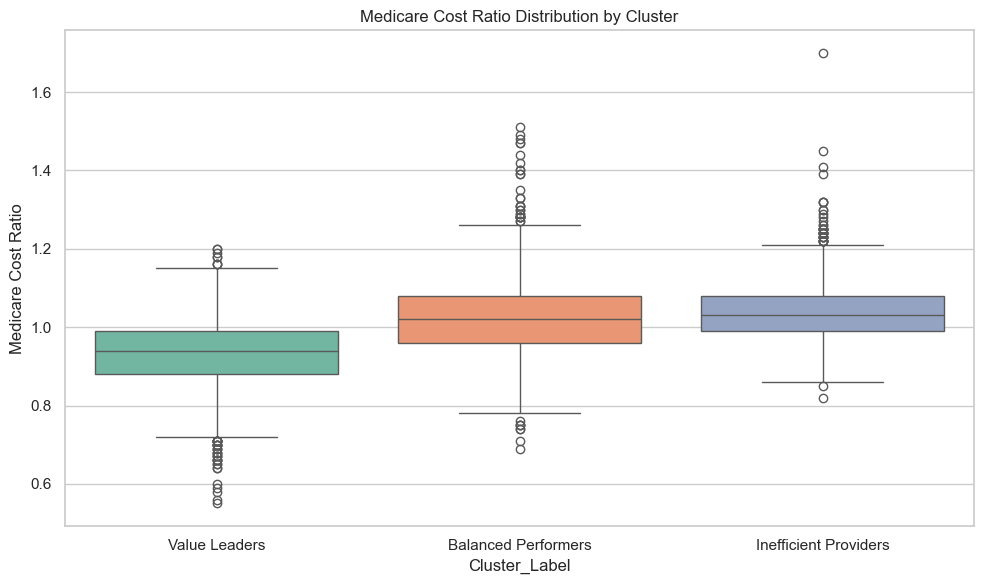

In [7]:
# Boxplot: Medicare Cost Ratio by Cluster Label
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Cluster_Label', y='Medicare_Cost_Ratio', hue='Cluster_Label', palette='Set2', legend=False)
plt.title('Medicare Cost Ratio Distribution by Cluster')
plt.xlabel('Cluster_Label')
plt.ylabel('Medicare Cost Ratio')
plt.tight_layout()
plt.show()

# Boxplot: Quality Star Ratings by Cluster Label

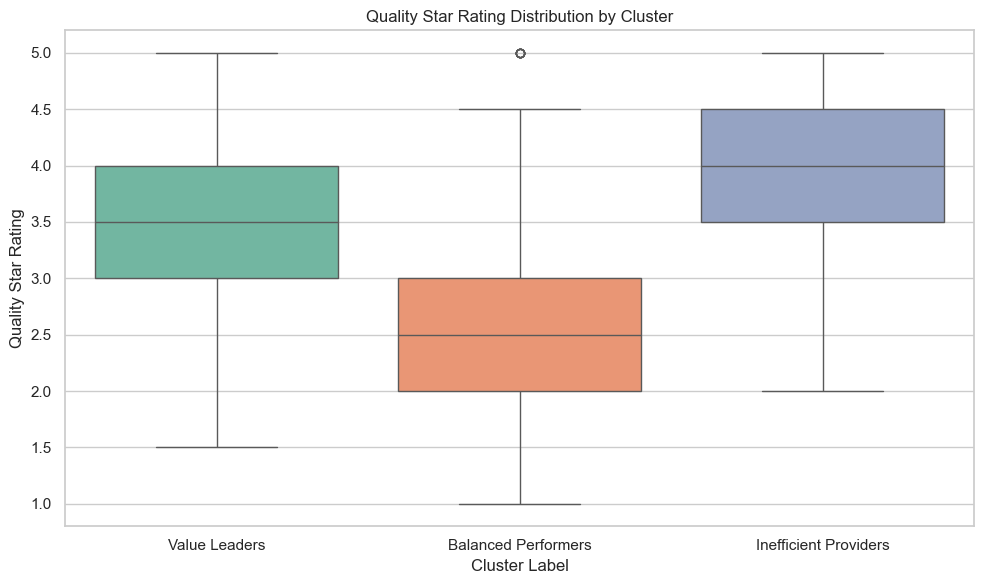

In [8]:
# Boxplot: Quality Star Ratings by Cluster Label
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Cluster_Label', y='Quality_Star', hue='Cluster_Label', palette='Set2', legend=False)
plt.title('Quality Star Rating Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Quality Star Rating')
plt.tight_layout()
plt.show()

# Countplot: Ownership Distribution by Cluster

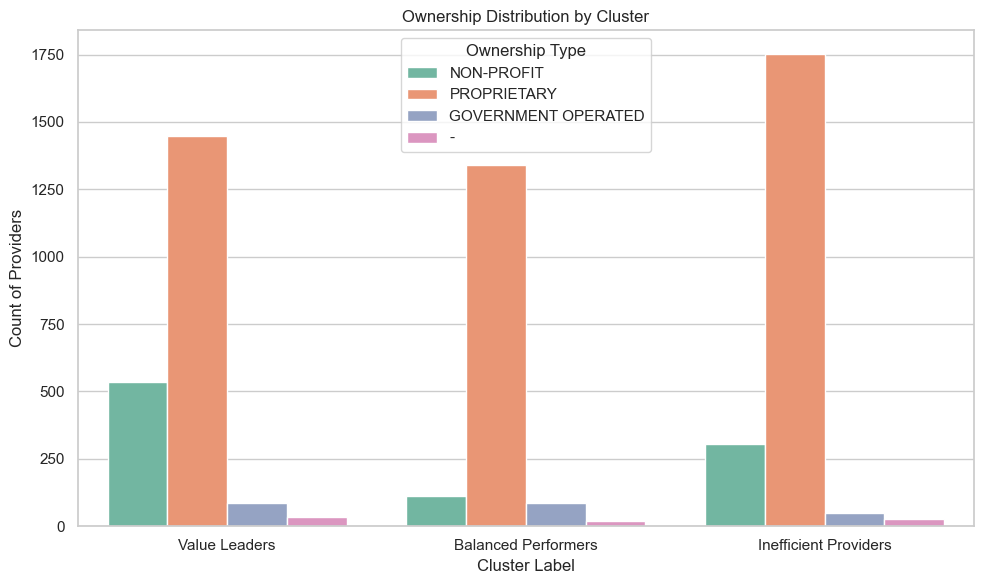

In [9]:
# Countplot: Ownership Distribution by Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Cluster_Label', hue='Ownership', palette='Set2')
plt.title('Ownership Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Count of Providers')
plt.legend(title='Ownership Type')
plt.tight_layout()
plt.show()

# Summary: Stats by Cluster

In [10]:
# Assign human-readable labels based on Medicare Cost Ratio
cluster_means = data.groupby('Cluster')[numeric_cols].mean().round(2)
cluster_means_sorted = cluster_means.sort_values(by='Medicare_Cost_Ratio')

cluster_labels = {
    cluster_means_sorted.index[0]: "Value Leaders",
    cluster_means_sorted.index[1]: "Balanced Performers",
    cluster_means_sorted.index[2]: "Inefficient Providers"
}
data['Cluster_Label'] = data['Cluster'].map(cluster_labels)

# Generate summary table grouped by human-readable labels
summary = data.groupby('Cluster_Label').agg({
    'Medicare_Cost_Ratio': 'mean',
    'Episode_Count': 'mean',
    'Quality_Star': 'mean',
    'PPH_Rate': 'mean',
    'DTC_Rate': 'mean',
    'PPR_Rate': 'mean'
}).round(2)

# Display table
print("Summary Table by Cluster:")
display(summary)


Summary Table by Cluster:


,Medicare_Cost_Ratio,Episode_Count,Quality_Star,PPH_Rate,DTC_Rate,PPR_Rate
Cluster_Label,,,,,,
Balanced Performers,1.02,848.26,2.58,13.05,68.36,3.86
Inefficient Providers,1.04,2148.07,4.06,9.92,81.53,3.67
Value Leaders,0.93,972.19,3.37,8.45,82.99,4.10
